In [1]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.decomposition import PCA
import seaborn as sns
import datetime
from scipy.stats import sem
import matplotlib.cm as cm
import pathlib
import traceback
import gc
import configs

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from predify.utils.training import train_pcoders, eval_pcoders
from data.ValidationDataset import NoisyDataset

from models.networks_2022 import BranchedNetwork

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve, ShuffleSplit

#scores = cross_val_score(clf, X_train, y_train, cv=5)

In [2]:
netname = 'pnet'
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
pca_activations_dir = f'{engram_dir}4_activations_PCA/{netname}/'

In [3]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cpu


In [4]:
conv_idx = 2
t = 0

# Load and split data

In [5]:
data_filename = f'data_conv{conv_idx}_t{t}'
results = h5py.File(f'{pca_activations_dir}{data_filename}.hdf5', 'r')
X = np.array(results['X_pca'])
bgs = np.array(results['bgs'])
snrs = np.array(results['snrs'])
dset_idxs = np.array(results['dset_idxs'])
results.close()

In [6]:
# Generate labels
snr_values = np.unique(snrs)
snr_values.sort()
snr_labels = np.arange(1, snr_values.size+1)
c = []
for snr in snrs:
    c.append(np.argwhere(snr_values==snr).item())
c = np.array(c)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, c, test_size=0.2)

# Cross-validate on train for hyperparameter choice

In [ ]:
Cs = np.logspace(-4.5, -2, 10)
scaler = StandardScaler()
model = SVC(kernel='rbf')
clf = make_pipeline(scaler,  model)
cv = ShuffleSplit(test_size=0.2, n_splits=5)
train_scores, test_scores = validation_curve(
    clf, X_train, y_train, param_name="svc__C", param_range=Cs, cv=cv
    )
test_scores.mean(axis=1)

# Fit to train data 

In [15]:
clf.fit(X_train, c_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', kernel='linear'))])

# Predict on test and summarize performance

In [16]:
yhat_test = clf.predict(X_test)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


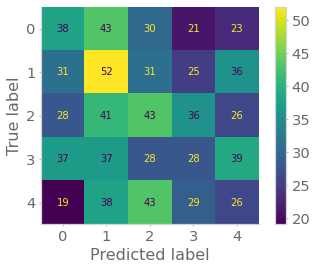

In [17]:
# Classifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cmat = confusion_matrix(y_test, yhat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=clf.classes_)
disp.plot()
plt.show()

In [18]:
# conv_idx = 3, t = 4
clf.score(X_test, y_test)

0.22584541062801933